In [2]:
#这次做regression可以体现rnn时间序列的特征，我们将依据时间用sin的曲线预测cos的曲线(每个时间点的x来预测该时间点的y)
import torch
from torch import nn
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(1)    # reproducible

In [3]:
# Hyper Parameters
TIME_STEP = 10      # rnn time step 
INPUT_SIZE = 1      # rnn input size ,某个时间点上的输入值只有y，因此是1
LR = 0.02           # learning rate
DOWNLOAD_MNIST = False  # set to True if haven't download the data

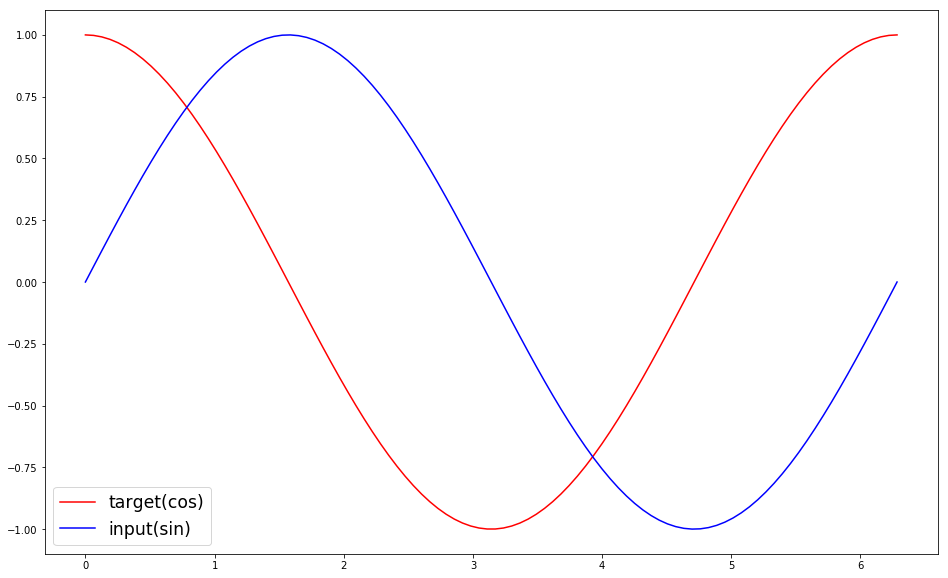

In [4]:
# show data 
steps = np.linspace(0,np.pi*2,100,dtype=np.float32)
x_np = np.sin(steps)
y_np = np.cos(steps)

plt.figure(figsize=(16,10))
plt.plot(steps,y_np,'r-',label='target(cos)')
plt.plot(steps,x_np,'b-',label='input(sin)') #这里的整个sin曲线是一个batch，其横轴就是time
plt.legend(loc='best',fontsize='xx-large')
plt.show()

In [5]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN,self).__init__()
        self.rnn = nn.RNN(
            input_size=1,
            hidden_size=32,
            num_layers=1,
            batch_first=True,
        )
        self.out = nn.Linear(32,1)
        
    def forward(self, x, h_state):  # 因为 hidden state 是连续的, 所以我们要一直传递这一个 state,所以要当成一个参数不断输入和更新
        # x (batch, time_step, input_size),这里的batch为1，time_step为10
        # h_state (n_layers, batch, hidden_size)
        # r_out (batch, time_step, output_size)
        r_out, h_state = self.rnn(x, h_state)   # h_state 也要作为 RNN 的一个输入,h_state这里只有一个
                                                # r_out size为 (batch * time_step(10) * hidden_size(32))

        outs = []    # 保存所有时间点的预测值,是以动态的方式呈现的，这也是pytorch具备tensorflow没有的优势
        for time_step in range(r_out.size(1)):    # 对每一个时间点计算 output，r_out.size(1)的大小为time_step的大小，这里为10
            outs.append(self.out(r_out[:, time_step, :])) #[:, time_step, :]的dim为batch * output_size,这里是1*32,经过self.out后变为1*1
                                                          #因此，最后的outs的dim是time_step个batch * 结果dim(这里为1)的，这里为10个1*1
        return torch.stack(outs, dim=1), h_state   #stack(dim=1)的作用是让每个batch的时间序列放到一起，则最后的dim变成了
                                                   #batch * time_step_ * 结果的dim(这里为1),这里为1*10*1,stack具体用法看下面

In [6]:
#上面的forwawrd也可以写成不要loop，而用reshape整批计算的形式
def forward(self, x, h_state):
    r_out, h_state = self.rnn(x, h_state)
    r_out = r_out.view(-1, 32)
    outs = self.out(r_out)
    return outs.view(-1, 32, TIME_STEP), h_state

In [8]:
#注意tensor.stack的()使用
a=torch.range(1,9).view(3,3)
b=a*10
c=b*10

print(a)
print(b)
print(c)

#print(torch.stack((a,b,c)))
print(torch.stack((a,b,c),dim=1))
#print(torch.stack((a,b,c),dim=2))
print((torch.stack((a,b,c))).shape)

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])
tensor([[10., 20., 30.],
        [40., 50., 60.],
        [70., 80., 90.]])
tensor([[100., 200., 300.],
        [400., 500., 600.],
        [700., 800., 900.]])
tensor([[[  1.,   2.,   3.],
         [ 10.,  20.,  30.],
         [100., 200., 300.]],

        [[  4.,   5.,   6.],
         [ 40.,  50.,  60.],
         [400., 500., 600.]],

        [[  7.,   8.,   9.],
         [ 70.,  80.,  90.],
         [700., 800., 900.]]])
torch.Size([3, 3, 3])


D:\anaconda\envs\py37\lib\site-packages\ipykernel_launcher.py:2: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
  


In [9]:
rnn = RNN()
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)


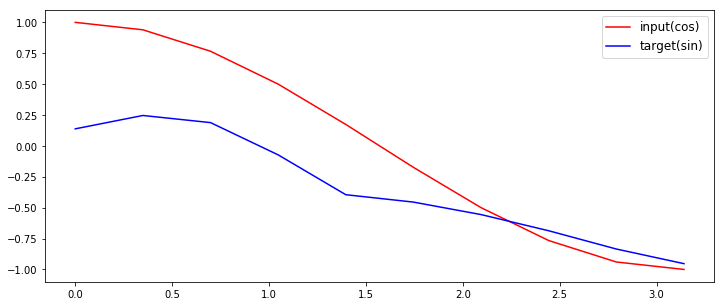

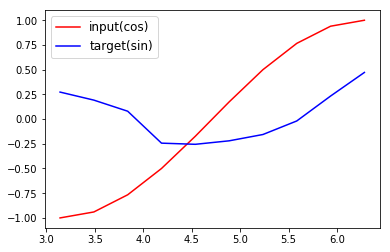

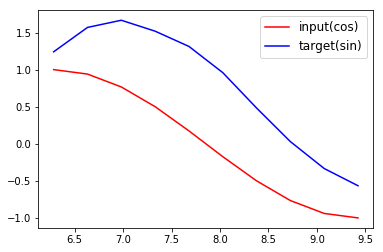

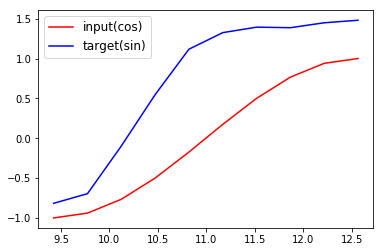

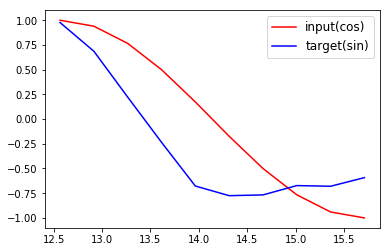

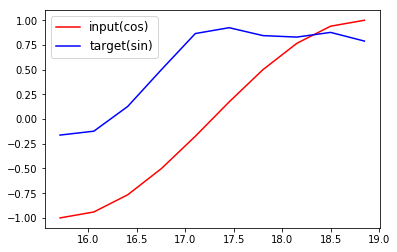

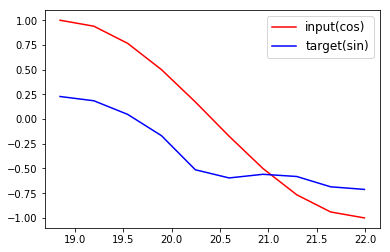

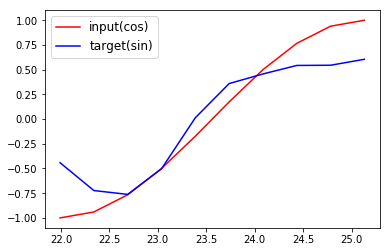

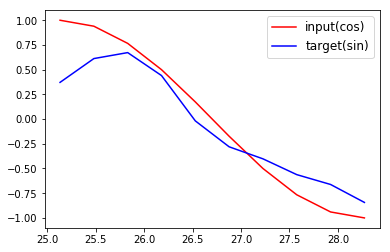

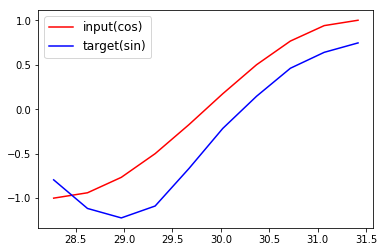

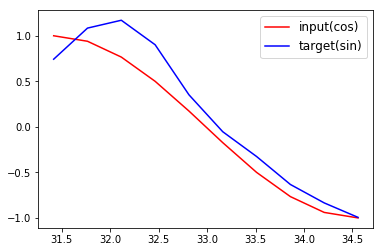

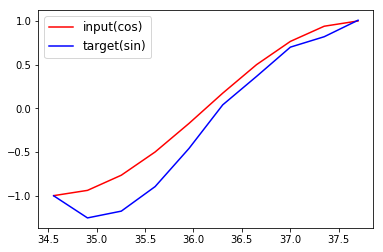

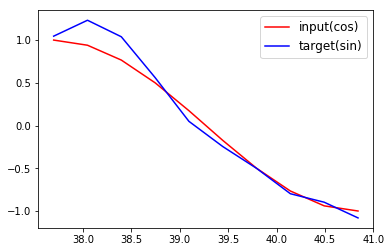

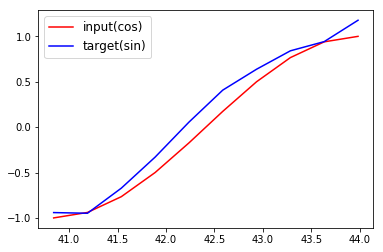

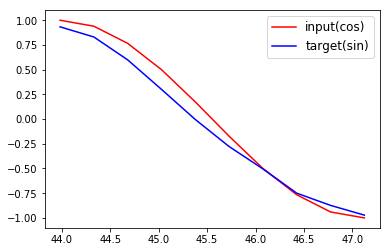

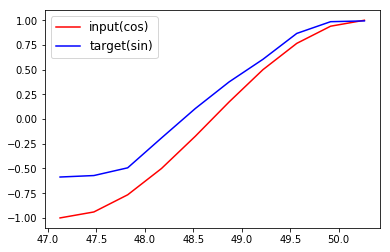

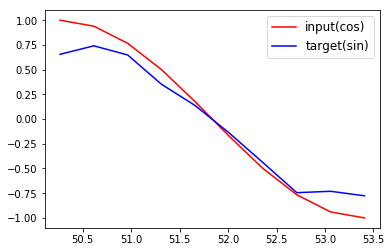

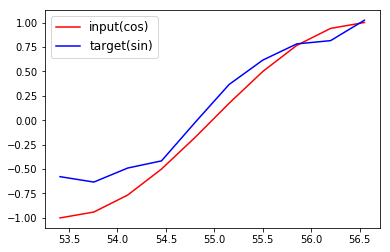

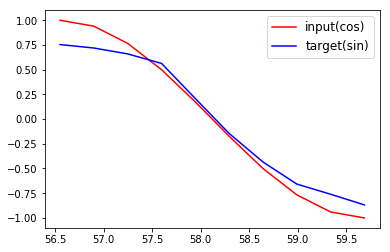

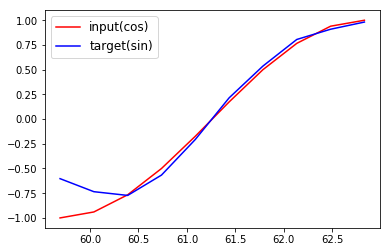

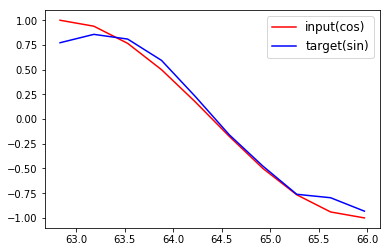

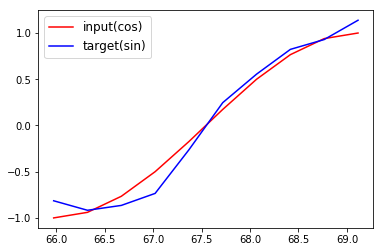

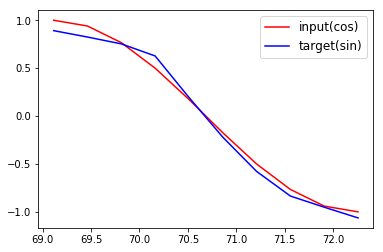

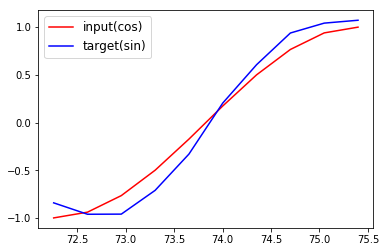

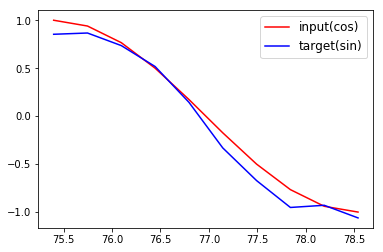

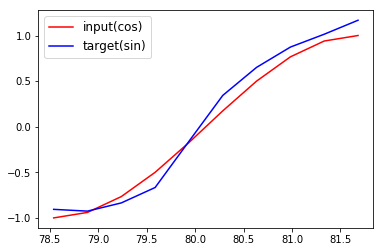

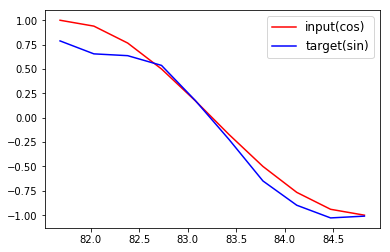

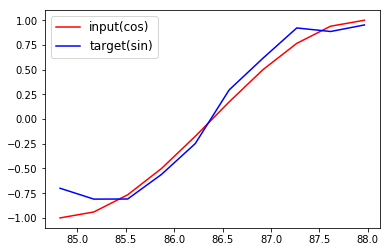

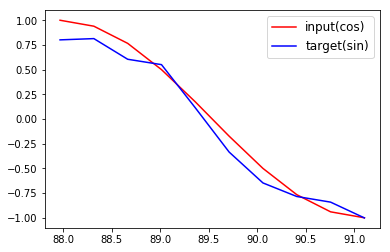

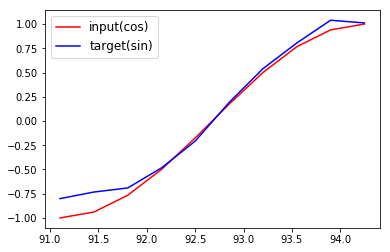

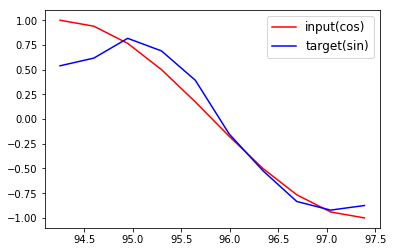

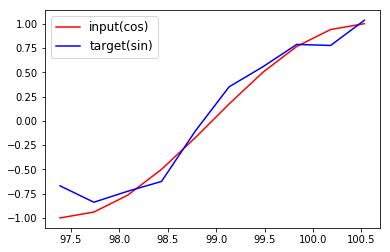

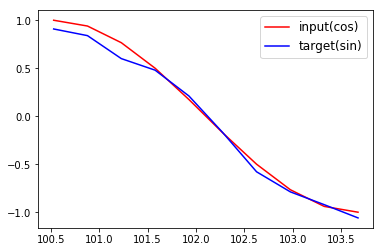

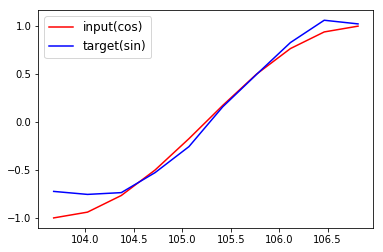

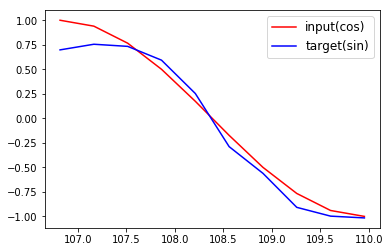

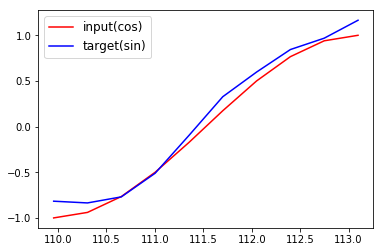

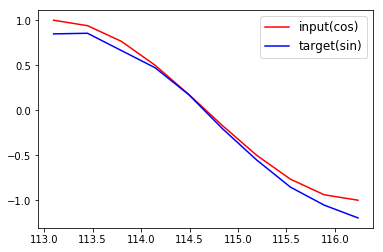

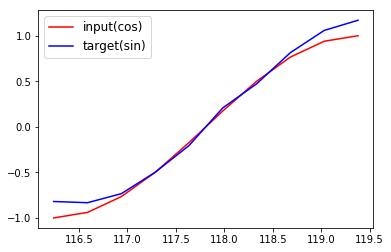

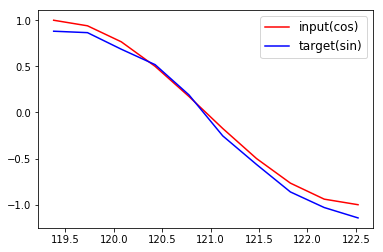

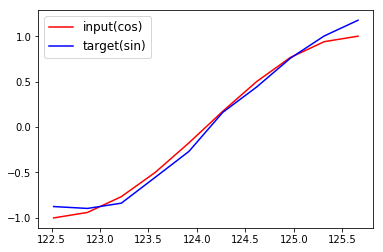

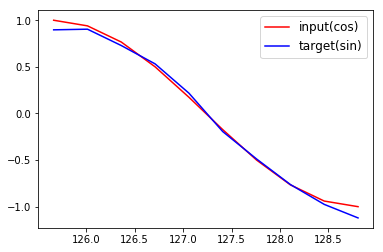

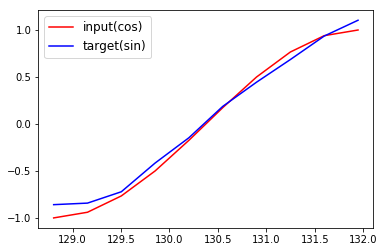

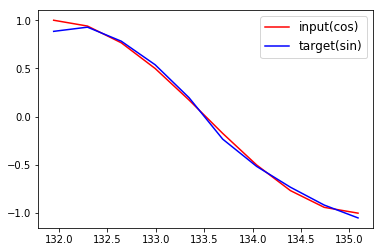

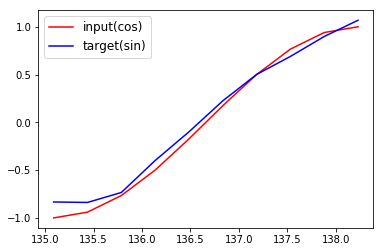

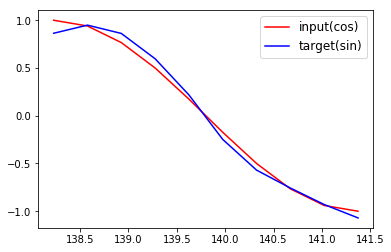

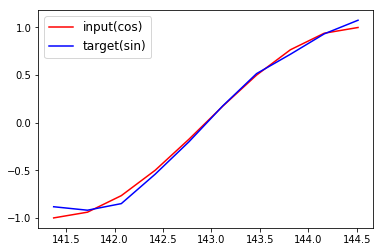

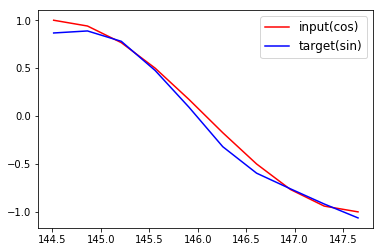

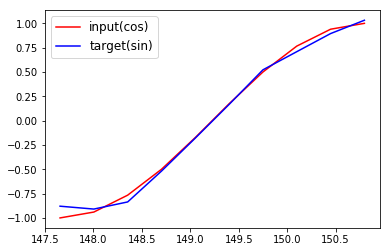

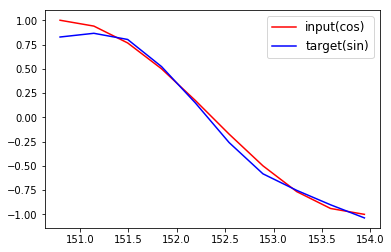

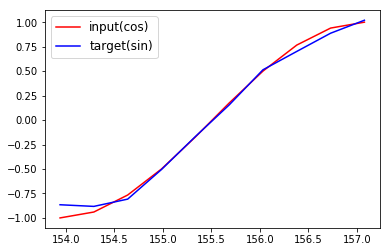

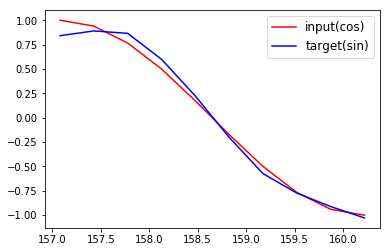

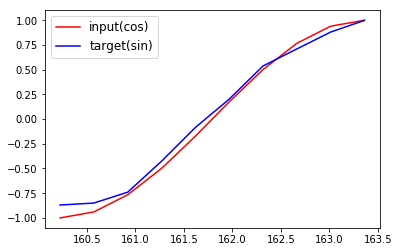

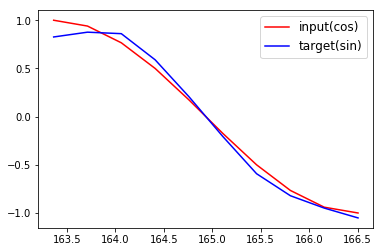

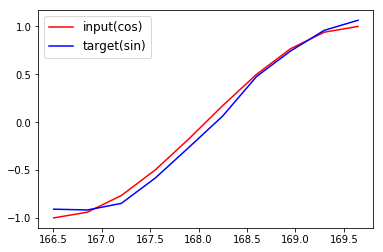

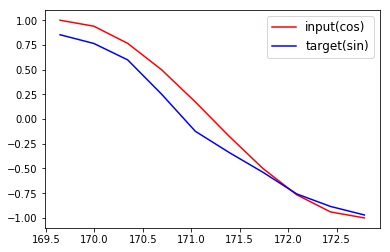

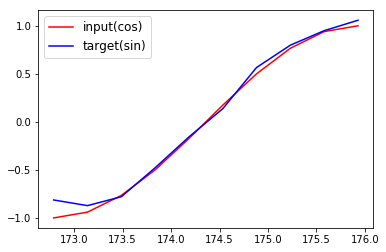

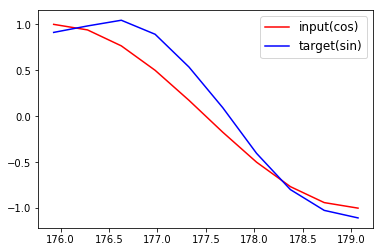

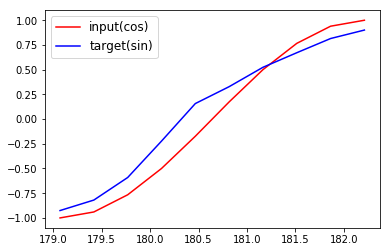

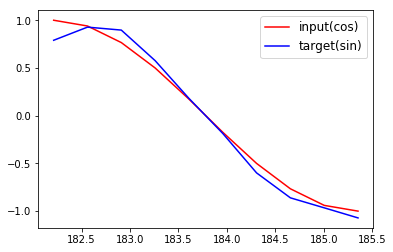

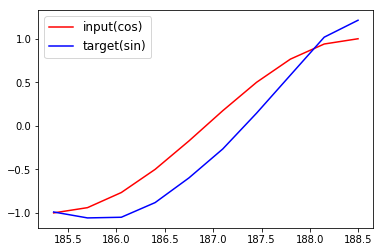

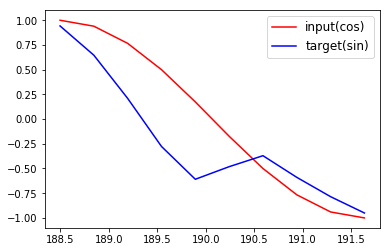

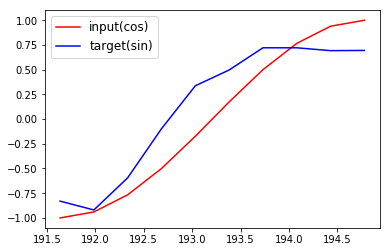

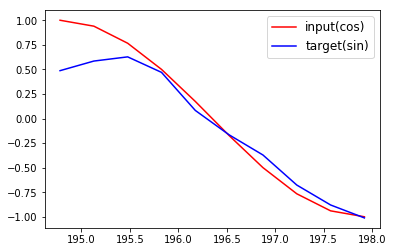

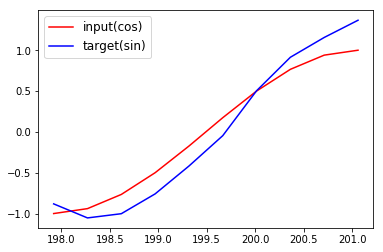

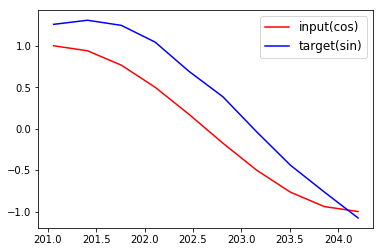

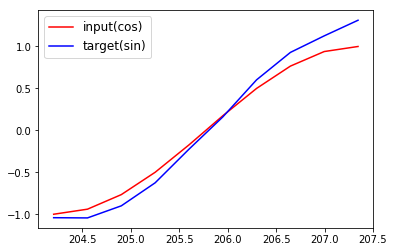

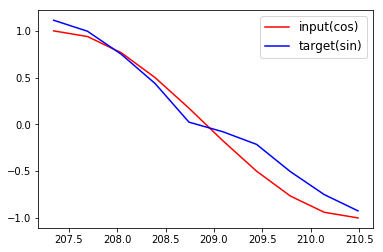

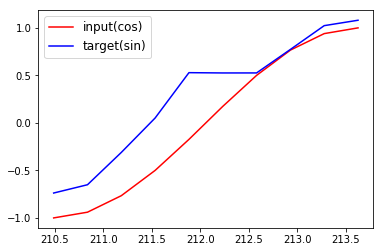

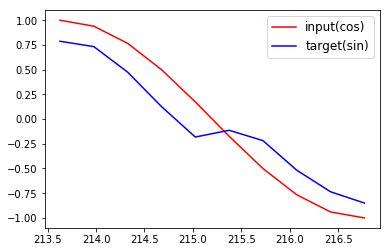

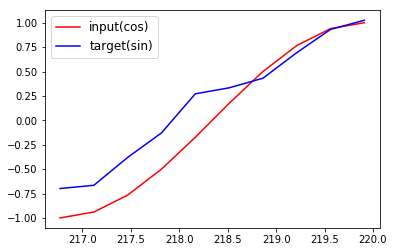

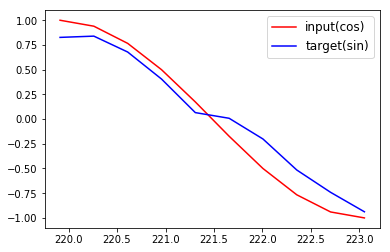

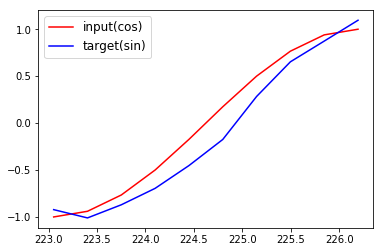

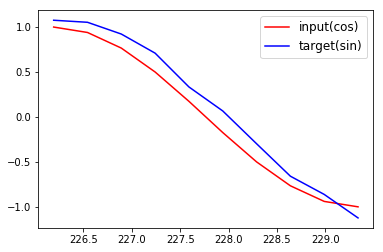

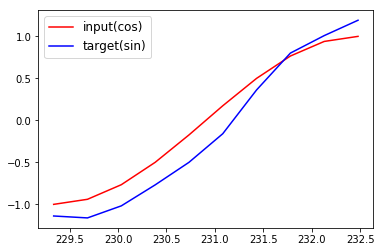

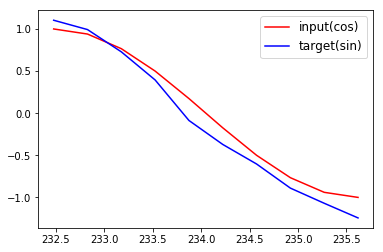

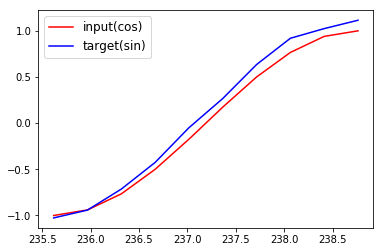

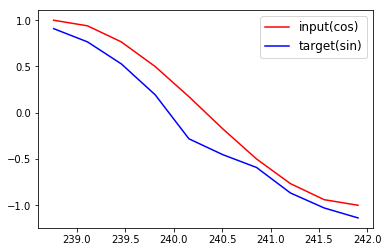

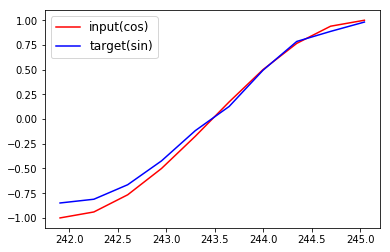

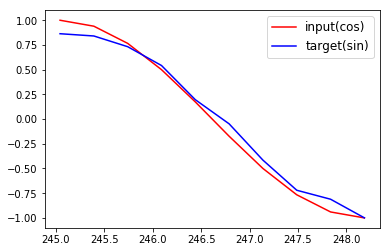

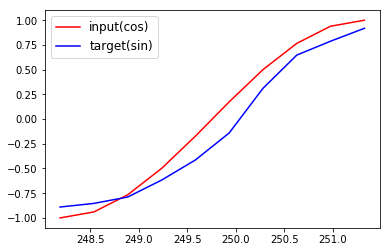

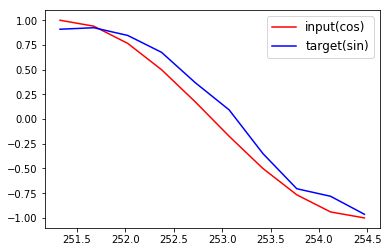

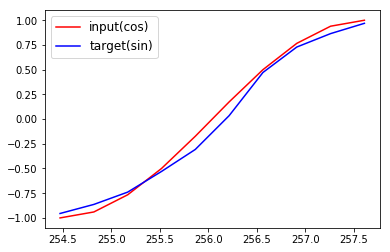

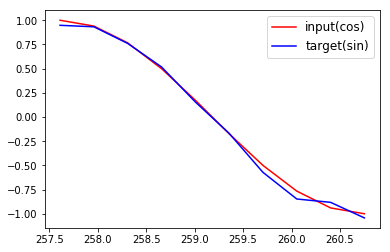

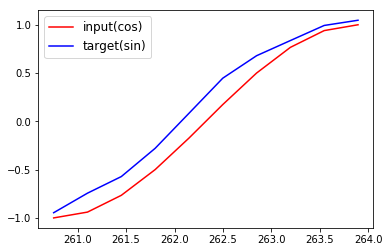

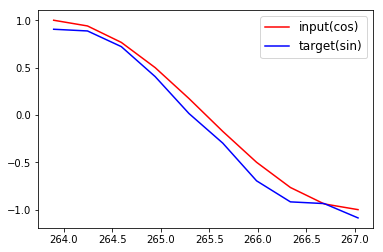

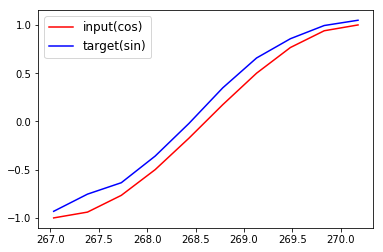

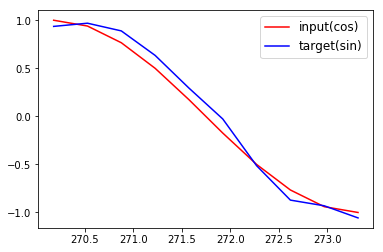

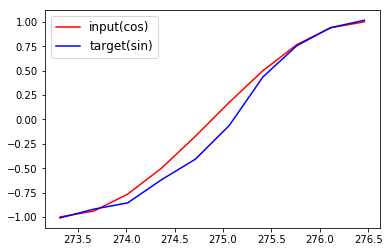

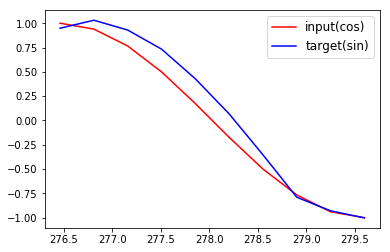

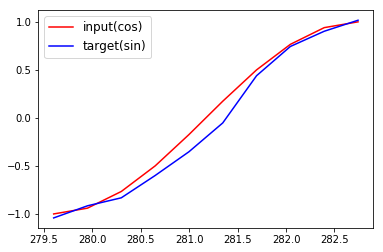

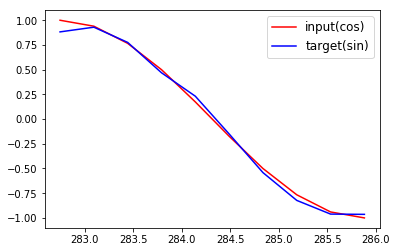

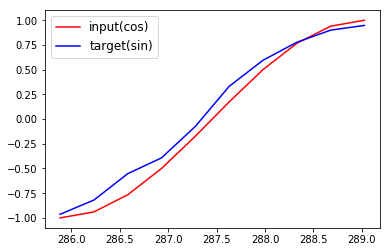

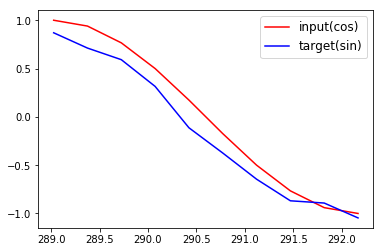

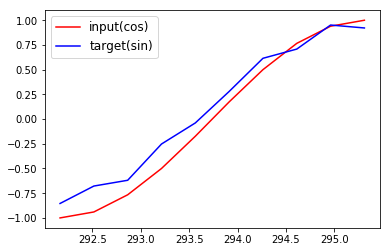

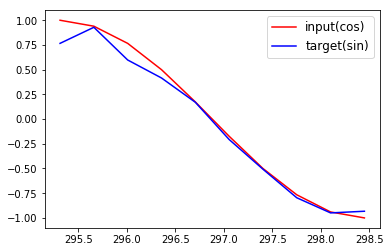

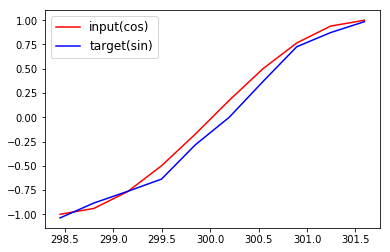

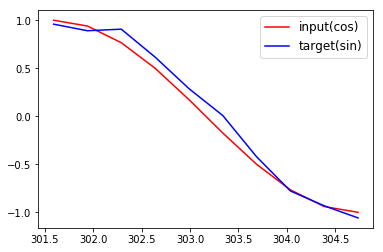

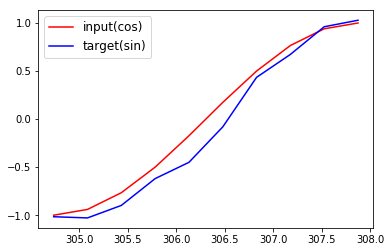

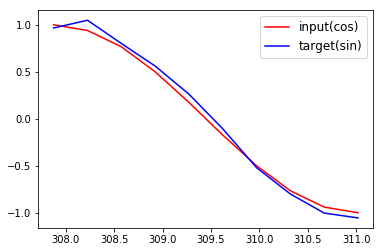

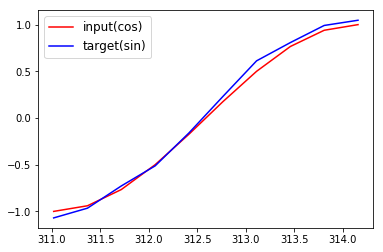

In [12]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all rnn parameters
loss_func = nn.MSELoss()

h_state = None   # hidden state的初始值，可以设成 None

plt.figure(1, figsize=(12, 5))       #可以在同一个图上一直画下去，但是notebook不支持这个功能
plt.ion()           # continuously plot

for step in range(100):     #这里将曲线按阶段来训练，即每一个pi的时间段训练一次，实际上相当于多个batch按时间排列，
                            # 以查看学习效果按时间的变化程度，但是在rnn的输入x中batch的dim仍为1
    start, end = step * np.pi, (step+1)*np.pi   # time steps
    # sin 预测 cos
    steps = np.linspace(start, end, TIME_STEP, dtype=np.float32)       #这里设置了TIME_STEP,为10
    x_np = np.sin(steps)    # float32 for converting torch FloatTensor
    y_np = np.cos(steps)

    x = torch.from_numpy(x_np[np.newaxis, :, np.newaxis])             #shape (batch, time_step, input_size)，这里为1*10*1
    y = torch.from_numpy(y_np[np.newaxis, :, np.newaxis])
    #x = Variable(torch.from_numpy(x_np[np.newaxis, :, np.newaxis])) 
    #y = Variable(torch.from_numpy(y_np[np.newaxis, :, np.newaxis])) #不封装应该也可以
    
    prediction, h_state = rnn(x, h_state)   # rnn 对于每个 step 的 prediction, 还有最后一个 step 的 h_state
    # !!  下一步重要 !!
    # h_state = h_state.data                                            #不封装：对h_state的处理，也可以不写这句话
    # h_state = Variable(h_state.data)        #封装：.data从容器中取出，再重新封装，才能放入下一个 iteration, 不然会报错

    loss = loss_func(prediction, y)     # MSE loss
    optimizer.zero_grad()               # clear gradients for this training step
    loss.backward(retain_graph=True)    # backpropagation, compute gradients
    optimizer.step()                    # apply gradients
    
    # plotting
    plt.plot(steps, y_np.flatten(), 'r-',label='target(sin)')           #这里y_np的dim为10，flatten()没有意义，但是可能其他例子需要
    plt.plot(steps, prediction.data.numpy().flatten(), 'b-',label='input(cos)') #prediction 的dim是1*10*1，是tensor
    plt.legend(loc='best',fontsize='large')
    plt.draw(); plt.pause(0.05)

plt.ioff()
plt.show()

#由于拿的样本输入x是sin的数据，样本输出y是cos的数据，因此相当于用sin预测cos，由于rnn的时间学习性，可以明显看到随着时间推移，两条线重合